In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM
df_tsfresh_feats = pd.read_csv('../data/processed/train_test_tsfresh.csv',parse_dates = ["id"]).fillna(method='bfill')


## Load data

In [91]:
df_tsfresh_feats_piv = df_tsfresh_feats.pivot_table(index = 'id',columns = ["Unnamed: 0"])

df_tsfresh_feats_piv.head()


value__abs_energy  \
Unnamed: 0          primary_cleaner.input.copper_sulfate   
id                                                         
2016-01-15 04:00:00                         16152.377193   
2016-01-15 08:00:00                         30073.585261   
2016-01-15 12:00:00                         47439.824148   
2016-01-15 16:00:00                         69327.513102   
2016-01-15 20:00:00                         91110.665212   

                                                      \
Unnamed: 0          primary_cleaner.input.depressant   
id                                                     
2016-01-15 04:00:00                       102.582358   
2016-01-15 08:00:00                       244.516532   
2016-01-15 12:00:00                       399.910646   
2016-01-15 16:00:00                       555.699203   
2016-01-15 20:00:00                       712.383602   

                                                     \
Unnamed: 0          primary_cleaner.input.feed_size   
id                                                    
2016-01-15 04:00:00                         52.5625   
2016-01-15 08:00:00                        105.1250   
2016-01-15 12:00:00                        157.6875   
2016-01-15 16:00:00                        210.2500   
2016-01-15 20:00:00                        262.8125   

                                                    \
Unnamed: 0          primary_cleaner.input.xanthate   
id                                                   
2016-01-15 04:00:00                       0.977644   
2016-01-15 08:00:00                       1.997480   
2016-01-15 12:00:00                       2.781653   
2016-01-15 16:00:00                       3.580734   
2016-01-15 20:00:00                       4.501241   

                                                            \
Unnamed: 0          primary_cleaner.state.floatbank8_a_air   
id                                                           
2016-01-15 04:00:00                           2.401805e+06   
2016-01-15 08:00:00                           4.966094e+06   
2016-01-15 12:00:00                           7.531441e+06   
2016-01-15 16:00:00                           1.010122e+07   
2016-01-15 20:00:00                           1.267083e+07   

                                                              \
Unnamed: 0          primary_cleaner.state.floatbank8_a_level   
id                                                             
2016-01-15 04:00:00                             2.489133e+05   
2016-01-15 08:00:00                             4.978898e+05   
2016-01-15 12:00:00                             7.474389e+05   
2016-01-15 16:00:00                             9.971676e+05   
2016-01-15 20:00:00                             1.247694e+06   

                                                            \
Unnamed: 0          primary_cleaner.state.floatbank8_b_air   
id                                                           
2016-01-15 04:00:00                           2.406948e+06   
2016-01-15 08:00:00                           4.971551e+06   
2016-01-15 12:00:00                           7.527727e+06   
2016-01-15 16:00:00                           1.008945e+07   
2016-01-15 20:00:00                           1.264262e+07   

                                                              \
Unnamed: 0          primary_cleaner.state.floatbank8_b_level   
id                                                             
2016-01-15 04:00:00                             2.666725e+05   
2016-01-15 08:00:00                             5.169959e+05   
2016-01-15 12:00:00                             7.666856e+05   
2016-01-15 16:00:00                             1.016782e+06   
2016-01-15 20:00:00                             1.266580e+06   

                                                            \
Unnamed: 0          primary_cleaner.state.floatbank8_c_air   
id                                                           
2016-01-15 04:00:00          

In [95]:
df_flat = df_tsfresh_feats_piv.copy()
df_flat.columns = ['_'.join(col).strip() for col in df_flat.columns.values]
df_flat["value__length_primary_cleaner.input.feed_size"].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30.])

In [3]:
df_raw_feats = pd.read_csv('../data/processed/train_test_raw.csv',parse_dates=['date']).set_index('date')


In [4]:
# Load target:
df_target = pd.read_csv(f'../data/interim/train_data/all_train.csv',parse_dates=['date'])[['date','rougher.output.recovery']].set_index('date')
df_target.head()



,rougher.output.recovery
date,
2016-01-15 00:00:00+00:00,87.107763
2016-01-15 01:00:00+00:00,86.843261
2016-01-15 02:00:00+00:00,86.842308
2016-01-15 03:00:00+00:00,87.226430
2016-01-15 04:00:00+00:00,86.688794


Pull the target, attach it to `df_flat`:

In [5]:
df_flat['target'] = df_target[['rougher.output.recovery']]
df_flat['month'] = df_flat.index.month
df_flat.plot(y=['month','target'])
df_flat = df_flat[~df_flat['target'].isna()]


X_train =df_flat[df_flat.month<7].drop(['target'],axis = 1)
X_test =df_flat[df_flat.month>=7].drop(['target'],axis = 1)

y_train =df_flat[df_flat.month<7]['target']
y_test =df_flat[df_flat.month>=7]['target']


NameError: name 'df_flat' is not defined

# Build a ML model

In [42]:

model = XGBoost(X_train,y_train,X_test,y_test,params = {'nthread': -1,
                 'max_depth': 10,
                 'eta': 0.1,
                 'objective': 'reg:linear',
                 'colsample_bytree': 0.01,
                 'subsample': 0.1,'silent':True},num_round = 3000,esr = 200)

[0]	train-rmse:75.6693	valid-rmse:75.4276
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[50]	train-rmse:10.0397	valid-rmse:12.9378
[100]	train-rmse:8.26104	valid-rmse:13.5443
[150]	train-rmse:7.26159	valid-rmse:13.9808
[200]	train-rmse:6.4621	valid-rmse:13.8824
Stopping. Best iteration:
[35]	train-rmse:10.8468	valid-rmse:12.8348

Result on validation data:  1.749932936125983


In [41]:
from sklearn.ensemble import RandomForestRegressor
from src.models.model import mase

rf = RandomForestRegressor(n_estimators = 40,max_depth = 8,n_jobs=-1,verbose = 1,random_state=123)
rf.fit(X_train,y_train)
score = mase(y_test,rf.predict(X_test))
print(f'Score valid = {score}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed:    0.0s finished


Score valid = 5.932235875570598


# Build on raw data

In [6]:
## Build that same XGBoost on the raw data:
from src.models.model import mase

df_raw_feats['target'] = df_target[['rougher.output.recovery']]

df_raw_feats.dropna(inplace=True)

X_train_raw =df_raw_feats[df_raw_feats.month<7].drop(['target'],axis = 1)
X_test_raw =df_raw_feats[df_raw_feats.month>=7].drop(['target'],axis = 1)

y_train_raw =df_raw_feats[df_raw_feats.month<7]['target']
y_test_raw =df_raw_feats[df_raw_feats.month>=7]['target']

model = XGBoost(X_train_raw,y_train_raw,X_test_raw,y_test_raw,params = {'nthread': 4,
                 'max_depth': 7,
                 'eta': 0.5,
                 'objective': 'reg:linear',
                 'colsample_bytree': 0.1,
                 'subsample': 0.2,'silent':True},num_round = 40,esr = 200);

score = mase(y_test_raw,model.guess(X_test_raw))
print(f'Score valid = {score}')

[0]	train-rmse:43.7932	valid-rmse:46.0891
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[39]	train-rmse:11.0977	valid-rmse:20.9457
Result on validation data:  1.2743778474325913
Score valid = 1.2743778474325913


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from src.models.model import mase
rf = RandomForestRegressor(n_estimators = 100,max_depth = 6 ,n_jobs=-1,verbose = 1,random_state=123,min_samples_split=5,criterion = 'mae')
rf.fit(X_train_raw,y_train_raw)
score = mase(y_test_raw,rf.predict(X_test_raw))
print(f'Score valid = {score}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   32.2s


Score valid = 9.421683092326194


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [12]:
from skgarden import RandomForestQuantileRegressor

rf_quantile = RandomForestQuantileRegressor(n_estimators =100,max_depth=6,criterion='mae',random_state=123,n_jobs =-1)
rf_quantile.fit(X_train_raw,y_train_raw)
score = mase(y_test_raw,rf_quantile.predict(X_test_raw))
print(f'Score valid = {score}')

Score valid = 9.457170543526974


In [23]:
score = mase(y_test_raw,rf_quantile.predict(X_test_raw,45))
print(f'Score valid = {score}')

Score valid = 8.690994606950268


# Keras quantile regressions

In [ ]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

optimizer = tf.train.AdamOptimizer(0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

def keras_pred(x_train, train_labels, x_test, q):
    print(q)
    # Set input_dim for the number of features.
    if len(x_train.shape) == 1:
        input_dim = 1
    else:
        input_dim = x_train.shape[1]
    model = keras.Sequential([
      keras.layers.Dense(UNITS, activation=tf.nn.relu,
                         input_dim=input_dim),
      keras.layers.Dense(UNITS, activation=tf.nn.relu),
      keras.layers.Dense(1)
    ])
    
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
    model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=0, validation_split=0.2, callbacks=[early_stop])
    
    # Predict the quantile
    return model.predict(x_test)

preds.loc[preds.method == 'Keras', 'pred'] = np.concatenate(
    [keras_pred(x_train_expanded, train_labels, x_test_expanded, q) 
     for q in QUANTILES]) 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0

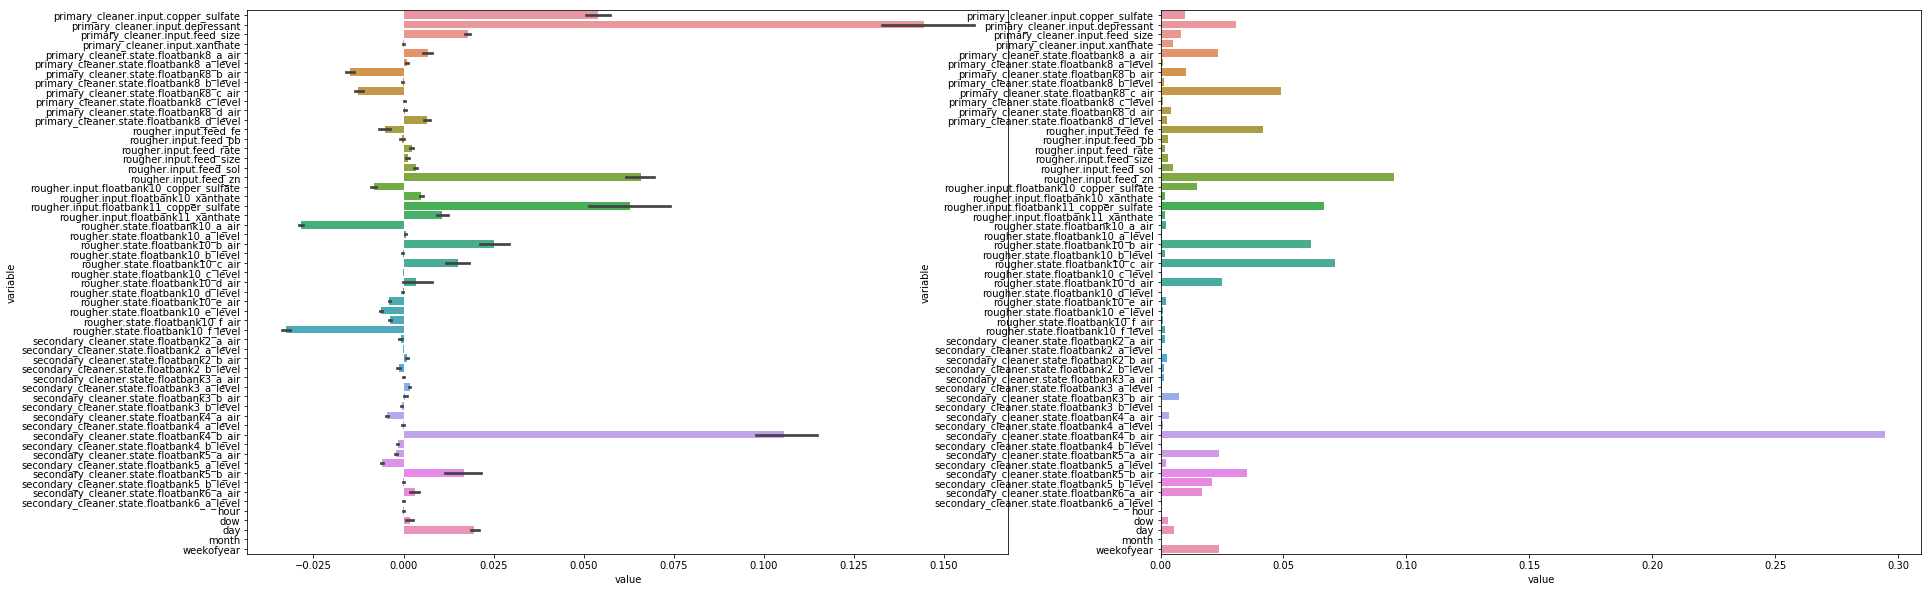

In [24]:
import seaborn as sns
from mlxtend.evaluate import feature_importance_permutation
from sklearn.metrics import make_scorer
imp_vals, imp_all = feature_importance_permutation(predict_method=rf.predict, X=X_test_raw.values, y=y_test_raw.values, metric='r2', num_rounds=10,  seed=1)

fig,ax = plt.subplots(figsize = (30,10),ncols=2)

feat_df = pd.DataFrame(data=imp_all.T,columns = X_test_raw.columns).reset_index().melt(id_vars = 'index')
feat_df_rf = pd.DataFrame(data={'variable':X_test_raw.columns,'value':rf.feature_importances_})
sns.barplot(data = feat_df,y='variable',x='value',ax =ax[0])
sns.barplot(data = feat_df_rf,y='variable',x='value',ax =ax[1])


In [89]:
rf.feature_importances_.shape

(57,)

In [101]:
df_raw_feats = pd.read_csv('../data/processed/train_test_raw.csv',parse_dates=['date'])

In [109]:
x = df_raw_feats['date'] - df_raw_feats['date'].shift(1)
x.value_counts()

0 days 01:00:00        22710
122 days 01:00:00          2
243 days 01:00:00          1
0 days 00:59:59            1
-717 days +14:00:00        1
Name: date, dtype: int64

rougher.output.recovery    320
dtype: int64